<a href="https://colab.research.google.com/github/rattlesczck/Chatbots/blob/main/Chatbot_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This project is almost the same as the previous one where i created a chatbot using langgraph and using groq api (for llm)
# But one difference here is that this time i have tried to integrate the usage of web scraping from different sources on the web



In [1]:
! pip install langgraph langchain langsmith langchain_groq langchain_community
!pip install arxiv wikipedia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.4 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=4fc4343f49f89fcf9287ebe8c3284d8d4c9176e6862782274287ab73ba27e07f
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=29622ef6b4807289cf92b16c43141125cdcb766639adefcec8a158dd65119570
  Stored in directory: /root

In [20]:
from typing import Annotated
from typing_extensions import TypedDict

# Working with external tools
from langchain_community.utilities import ArxivAPIWrapper #(for research paper exploring)
from langchain_community.utilities import WikipediaAPIWrapper # to surf through wikipedia
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun

#Arxiv and wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=250)
arxiv_tool = ArxivQueryRun(api_wrapper= arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki_tool = WikipediaQueryRun(api_wrapper = api_wrapper)



In [21]:
wiki_tool.invoke("What is the Honda")

"Page: Honda\nSummary: Honda Motor Co., Ltd., commonly known as just Honda, is a Japanese multinational conglomerate automotive manufacturer headquartered in Minato, Tokyo, Japan.\nFounded in October 1946 by Soichiro Honda, Honda has been the world's la"

In [22]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyr"

In [23]:
tools = [wiki_tool, arxiv_tool]
from langgraph.graph.message import add_messages
#Langgraph application

class State(TypedDict):
  messages:Annotated[list, add_messages]


In [24]:
from langgraph.graph import StateGraph, START, END

graphbuilder = StateGraph(State)


In [25]:
from langchain_groq import ChatGroq
from google.colab import userdata

#Creating model
llm = ChatGroq(groq_api_key = userdata.get('chatbot_groq'), model_name="Gemma2-9b-It")



In [26]:
llm_with_tools = llm.bind_tools(tools=tools)


In [27]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}


In [28]:
from langgraph.prebuilt import ToolNode, tools_condition

In [29]:
graphbuilder.add_node("chatbot", chatbot)
graphbuilder.add_edge(START, "chatbot")
toolnode = ToolNode(tools = tools)
graphbuilder.add_node("tools", toolnode)


graphbuilder.add_conditional_edges(
    "chatbot", tools_condition
)

graphbuilder.add_edge("tools", "chatbot")
graphbuilder.add_edge("chatbot", END)



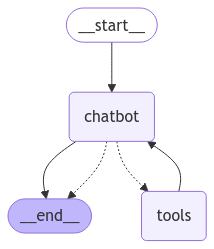

In [30]:
graph = graphbuilder.compile()
graphbuilder.compile()

In [33]:
user_input = input("User: ")
events = graph.stream({"messages": [("user", user_input)]}, stream_mode = "values")

for event in events:
  event["messages"][-1].pretty_print()


User: ellie nova
================================ Human Message =================================

ellie nova
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_gja0)
 Call ID: call_gja0
  Args:
    query: ellie nova
================================= Tool Message =================================
Name: wikipedia

Page: Ellie Black
Summary: Elsabeth Ann Black  (born September 8, 1995) is a Canadian artistic gymnast. She is a four-time Olympian, having represented her country at the 2012, 2016, 2020, and 2024 Olympic games. She is the 2017 World all-around silv
================================== Ai Message ==================================

Ellie Nova is likely a mispelling of Ellie Black, a Canadian artistic gymnast.
